# Pareto-NBD Population Model



#### References:
----------
David C. Schmittlein, Donald G. Morrison and Richard Colombo
Management Science,Vol. 33, No. 1 (Jan., 1987), pp. 1-24
"Counting Your Customers: Who Are They and What Will They Do Next,"
    
Fader, Peter & G. S. Hardie, Bruce (2005).
["A Note on Deriving the Pareto/NBD Model and Related Expressions."](http://brucehardie.com/notes/009/pareto_nbd_derivations_2005-11-05.pdf)

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm
import numpy as np
import warnings

from lifetimes import ParetoNBDFitter
from lifetimes.plotting import plot_period_transactions

from pymc_marketing.clv.models import ParetoNBDModel
from pymc_marketing.clv.distributions import ParetoNBD
from pymc_marketing.clv.utils import clv_summary

## Load Data

We will be working with the CDNOW Sample dataset, a common benchmark dataset in research for CLV and BTYD models

In [2]:
url_cdnow_rfm = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/datasets/clv_quickstart.csv"
url_cdnow_trans = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/tests/clv/datasets/cdnow_transactions.csv"
df = pd.read_csv(url_cdnow_rfm)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2357 entries, 0 to 2356
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   frequency       2357 non-null   int64  
 1   recency         2357 non-null   float64
 2   T               2357 non-null   float64
 3   monetary_value  2357 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 73.8 KB


In [3]:
df.head(5)

,frequency,recency,T,monetary_value
0,2,30.43,38.86,22.35
1,1,1.71,38.86,11.77
2,0,0.00,38.86,0.00
3,0,0.00,38.86,0.00
4,0,0.00,38.86,0.00


In [4]:
df.describe()

,frequency,recency,T,monetary_value
count,2357.000000,2357.000000,2357.000000,2357.000000
mean,1.042427,6.845787,32.715829,14.079045
std,2.190014,10.731400,3.326906,25.760960
min,0.000000,0.000000,27.000000,0.000000
25%,0.000000,0.000000,29.860000,0.000000
50%,0.000000,0.000000,32.710000,0.000000
75%,1.000000,12.000000,35.430000,21.360000
max,29.000000,38.430000,38.860000,299.630000


## Lifetimes Comparison

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

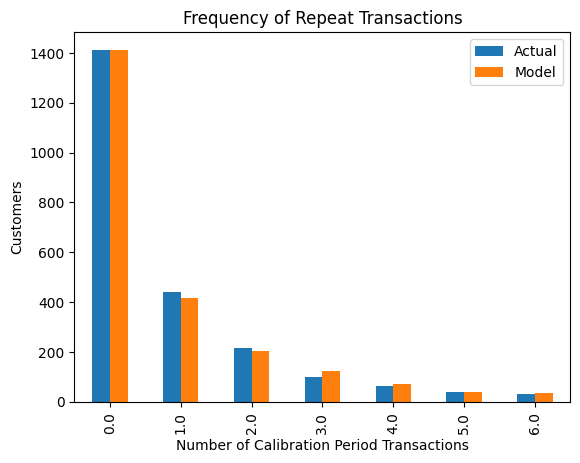

In [23]:
x = df["frequency"].values
t_x = df["recency"].values
T = df["T"].values

lft = ParetoNBDFitter()
lft.fit(x, t_x, T)
lt_fit = dict(lft.params_)

plot_period_transactions(lft)

Use the `ParetoNBD` distribution from `pymc-marketing` to simulate frequency and recency from fitted Lifetimes model parameters. This is useful for generating synthetic data as well as checking how well the parameters fit the original data.

This forms the basis of the `plot_period_transactions` plot from `lifetimes`.

In [7]:
rec_freq = pm.draw(ParetoNBD.dist(r=0.55,
                alpha=10.58,
                s=0.61,
                beta=11.67,
                T=T,
                size=len(T)))

pd.DataFrame({'frequency': rec_freq[...,1], 'recency': rec_freq[...,0], "T": T}).describe()

,frequency,recency,T
count,2357.000000,2357.000000,2357.000000
mean,1.070004,6.684982,32.715829
std,2.136219,10.600376,3.326906
min,0.000000,0.000000,27.000000
25%,0.000000,0.000000,29.860000
50%,0.000000,0.000000,32.710000
75%,1.000000,11.311684,35.430000
max,27.000000,37.757246,38.860000


<Axes: >

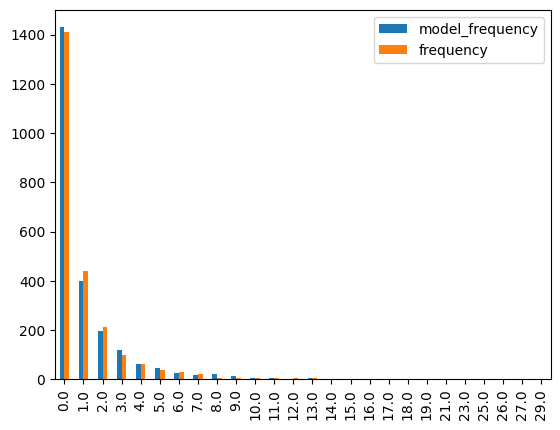

In [11]:
model_freq = rec_freq[...,1]

actual_counts = pd.Series(x).value_counts().sort_index()
simulated_counts = pd.Series(model_freq).value_counts().sort_index()
combined_counts = pd.DataFrame({"model_frequency": simulated_counts, "frequency": actual_counts}).fillna(0)
combined_counts.plot(kind="bar")

## PyMC Comparison

Construct an equivalent model with PyMC to illustrate the inner workings of the pymc-marketing model for comparison. 

This model uses Weibull default priors. For an interactive PDF go here:
https://homepage.divms.uiowa.edu/~mbognar/applets/weibull.html

The Weibull distribution is an intuitive prior distribution choice for the Pareto/NBD model because the `beta` parameter loosely corresponds to the expected value, and an `alpha` parameter value of 2 will rule out values which may cause sampling instability without being too restrictive. The Weibull distribution is also a variant of the generalized Gamma distribution that forms the conjugate priors of this model.

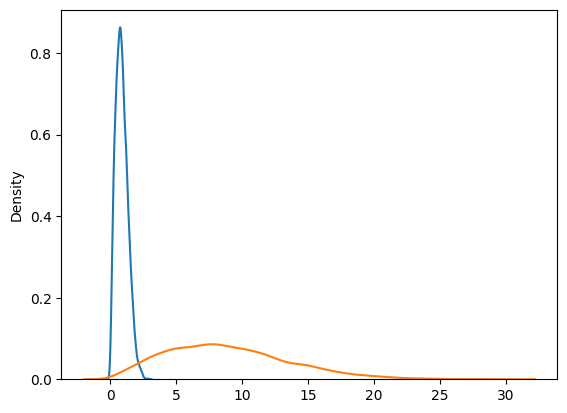

In [12]:
shape_prior = pm.draw(pm.Weibull.dist(alpha=2,beta=1, size=10_000))
scale_prior = pm.draw(pm.Weibull.dist(alpha=2,beta=10, size=10_000))

sns.kdeplot(shape_prior)
sns.kdeplot(scale_prior);

In [32]:
with pm.Model():
    r = pm.Weibull("r",alpha=2, beta=1)
    alpha = pm.Weibull("alpha", alpha=2, beta=10)
    s = pm.Weibull("s",alpha=2, beta=1)
    beta = pm.Weibull("beta", alpha=2, beta=10)
       
    llike = ParetoNBD("llike", r=r, alpha=alpha, s=s, beta=beta, T=T, observed=np.stack((t_x, x), axis=1))
    
    with warnings.catch_warnings():
        warnings.filterwarnings(
            message="Optimization Warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.",
            action="ignore",
            category=UserWarning,
        )
        
        # point estimate of parameters
        # idata = pm.find_MAP(include_transformed=False)
        
        # posterior distribution estimation
        
        # NUTS sampling can be very slow for this model due to the complex gradients
        # idata = pm.sample()
        # Slice sampling is much faster even though it requires more draws
        idata = pm.sample(step=pm.Slice(), draws=2000)
        
        # ADVI is also fast, but may not perform as well if the prior distribution selection was innappropriate
        # Handing outputs is also much different as the arviz idata object is not directly created from the output
        # mean_field = pm.fit(obj_optimizer=pm.adagrad_window(learning_rate=1e-2))
        
        # TODO: support for pytensor.hyp2f1 must be added for JAX and Numba to use external samplers
        # idata = pymc.sampling_jax.sample_blackjax_nuts()#(2000, tune=2000, target_accept=0.9)

az.summary(idata)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [r]
>Slice: [alpha]
>Slice: [s]
>Slice: [beta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 35 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r,0.563,0.046,0.479,0.650,0.002,0.001,762.0,1529.0,1.01
alpha,10.710,0.848,9.072,12.248,0.027,0.019,942.0,1594.0,1.01
s,0.616,0.115,0.411,0.830,0.006,0.005,323.0,911.0,1.01
beta,11.883,3.645,5.560,18.568,0.205,0.145,312.0,661.0,1.00


Note the rhat statistic warning here: This means the MCMC sampling chains are not identically distributed. It is recommended to do more draws with the Slice Sampler compared to MCMC.

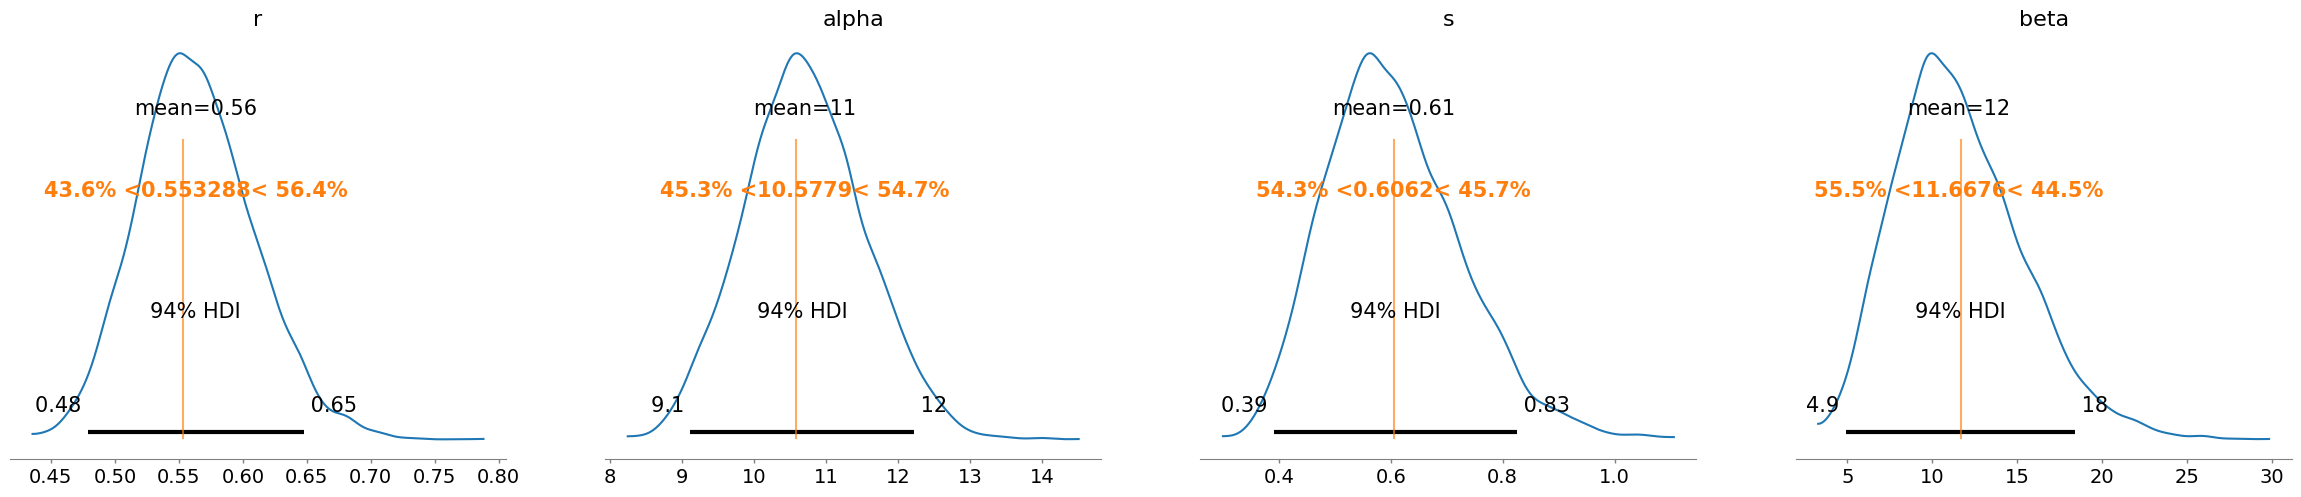

In [33]:
az.plot_posterior(idata_mcmc, ref_val=list(lt_fit.values()));

# ParetoNBD Model in `pymc_marketing`

Build models fit with both MAP and MCMC

In [70]:
df['customer_id'] = df.index



map_fit = ParetoNBDModel(df)

# TODO: build_model() and fit() methods both return NoneType objects. 

map_fit.build_model()
#pnbd.idata not yet created at this point

# pnbd.sample_prior_predictive() can be used after calling build_model and before fitting, 
# it will return an xarray.Dataset, but also create the pnbd.idata arviz.InferenceData object
map_fit.sample_prior_predictive()

# fitting the model will overwrite the prior_predictive idata object
map_fit.fit(fit_method='map')

# assert pnbd.fit_result == pnbd.idata.posterior

# TODO: Using pm.Slice() for inference requires changes to the ModelBuilder backend
# with pnbd.model:
    
#     sample_config = {
#         "step": pm.Slice(), 
#         "draws": 2000, 
#         "tune": 1000
#     }

#     pnbd.fit(**sample_config)

map_fit.idata

/Users/coltallen/Projects/pymc-marketing/pymc_marketing/clv/models/pareto_nbd.py:172: UserWarning: The Pareto/NBD model is still experimental. Please see code examples in documentation if model fitting issues are encountered.
  warnings.warn(
Sampling: [alpha, beta, likelihood, r, s]


Inference data with groups:
	> posterior
	> observed_data
	> fit_data

In [71]:
# fit same model with MCMC to compare return arviz outputs
mcmc_fit = ParetoNBDModel(df)
mcmc_fit.build_model()
mcmc_fit.fit()

mcmc_fit.idata

/Users/coltallen/Projects/pymc-marketing/pymc_marketing/clv/models/pareto_nbd.py:172: UserWarning: The Pareto/NBD model is still experimental. Please see code examples in documentation if model fitting issues are encountered.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r, alpha, s, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 204 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> fit_data

In [73]:
# running sample_prior_predictive after the model has been fit will append the xarray dataset to the fitted idata
mcmc_fit.sample_prior_predictive()
mcmc_fit.idata

Sampling: [alpha, beta, likelihood, r, s]


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> fit_data
	> prior
	> prior_predictive

In [74]:
# posterior predictive checks not directly supported,
# because GammaGammaModel and BetaGeoModel use Potentials to calculate logp
with mcmc_fit.model:
    post_idata = pm.sample_posterior_predictive(mcmc_fit.idata)

mcmc_fit.idata.extend(post_idata)
mcmc_fit.idata

Sampling: [likelihood]


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> fit_data
	> prior
	> prior_predictive
	> posterior_predictive

In [75]:
print("MAP Fit:") 
print(map_fit.fit_summary())

mcmc_fit.fit_summary()

MAP Fit:
r         0.560
alpha    10.591
s         0.550
beta      9.756
Name: value, dtype: float64


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r,0.562,0.046,0.479,0.650,0.001,0.001,1776.0,1865.0,1.0
alpha,10.678,0.829,9.095,12.232,0.020,0.014,1746.0,1866.0,1.0
s,0.602,0.112,0.404,0.823,0.003,0.002,1621.0,1531.0,1.0
beta,11.503,3.551,5.682,18.815,0.093,0.066,1376.0,1388.0,1.0


array([<Axes: title={'center': 'r'}>, <Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 's'}>, <Axes: title={'center': 'beta'}>],
      dtype=object)

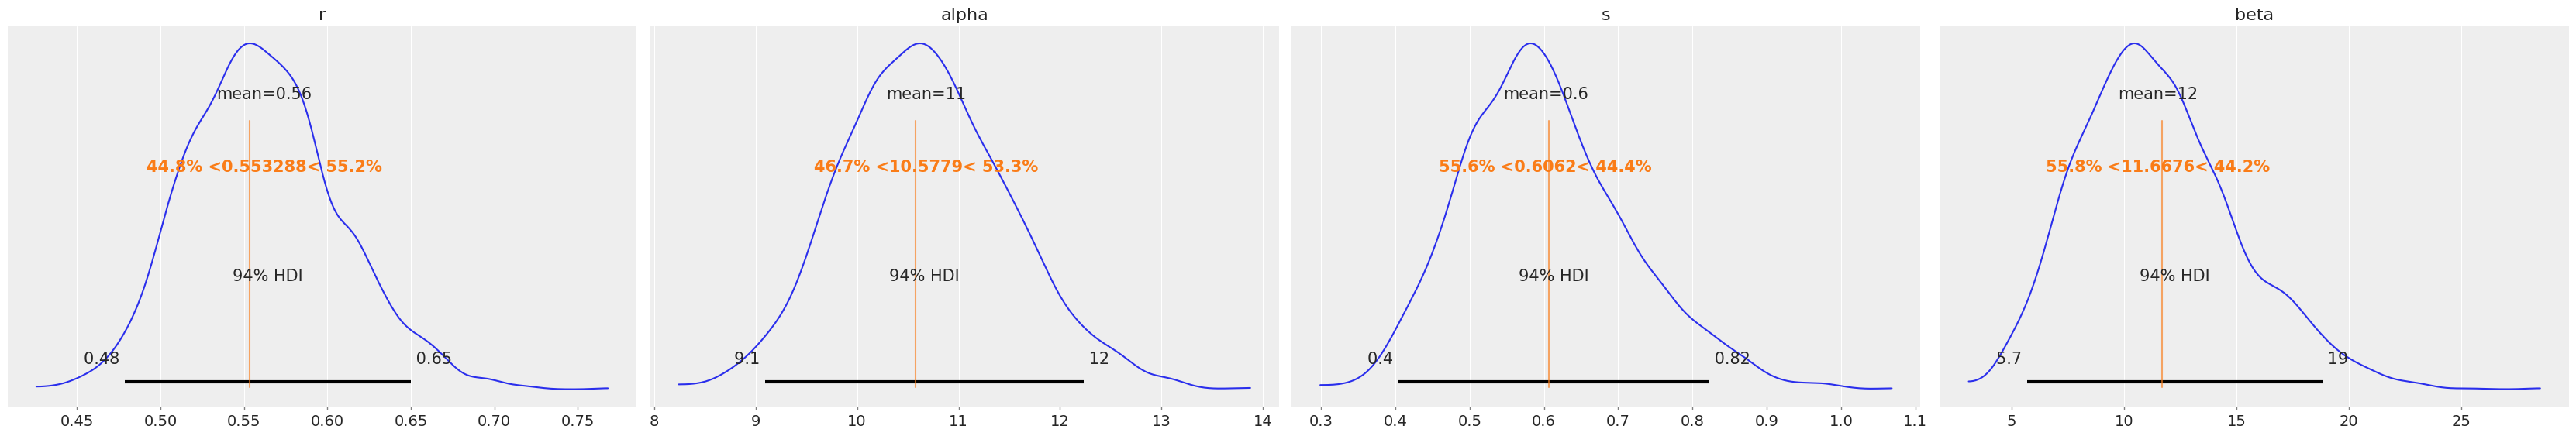

In [89]:
az.plot_posterior(mcmc_fit.idata, ref_val=list(lt_fit.values()))

Energy Plot
https://python.arviz.org/en/stable/api/generated/arviz.plot_energy.html

<Axes: >

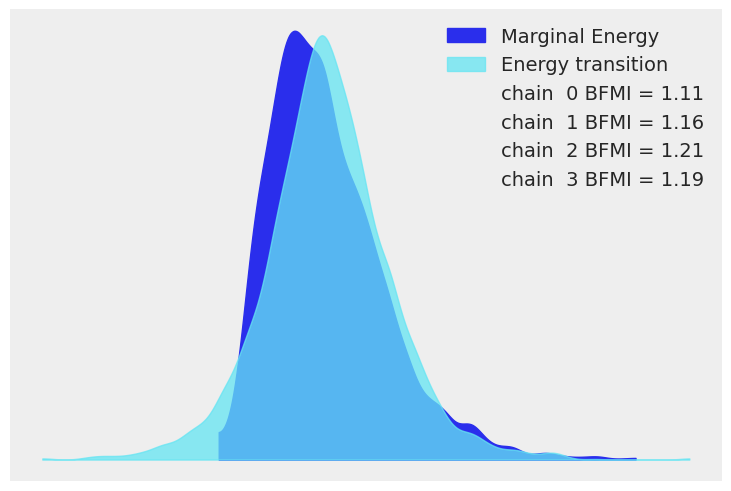

In [87]:
plt.style.use('arviz-darkgrid')

az.plot_energy(mcmc_fit.idata)

<Axes: title={'center': 'Plot Prior Predictive'}>

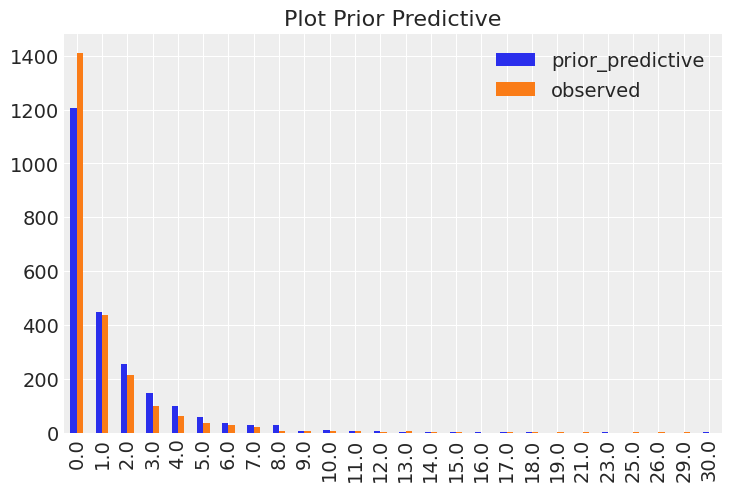

In [86]:
obs_freq = mcmc_fit.idata.observed_data['likelihood'][...,1].to_pandas().value_counts().sort_index()
prior_pred_freq = mcmc_fit.idata.prior_predictive['likelihood'][0][0][...,1].to_pandas().value_counts().sort_index()

plot_prior_pred = pd.DataFrame({"prior_predictive": prior_pred_freq, "observed": obs_freq})
plot_prior_pred.plot(kind="bar", title = "Plot Prior Predictive")

<Axes: title={'center': 'Plot Post Predictive'}>

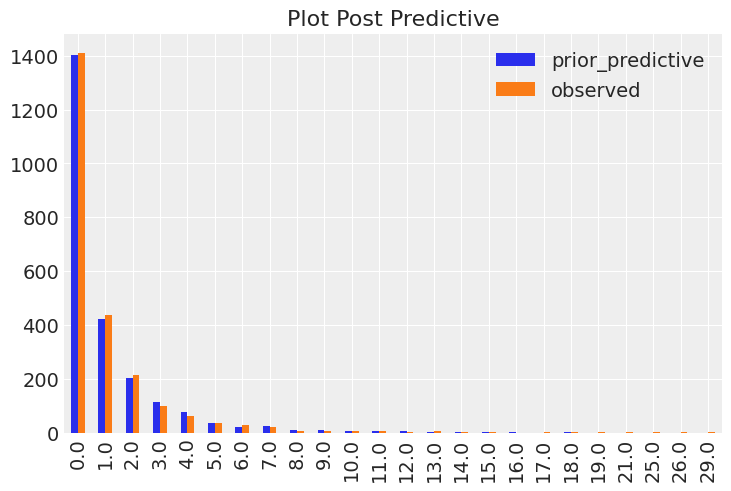

In [85]:
post_pred_freq = mcmc_fit.idata.posterior_predictive['likelihood'][0][0][...,1].to_pandas().value_counts().sort_index()

plot_post_pred = pd.DataFrame({"prior_predictive": post_pred_freq, "observed": obs_freq})
plot_post_pred.plot(kind="bar", title = "Plot Post Predictive")

#az.plot_dist(post_idata.posterior_predictive)


Text(0.5, 1.0, 'Prior Predictive ECDF Plot')

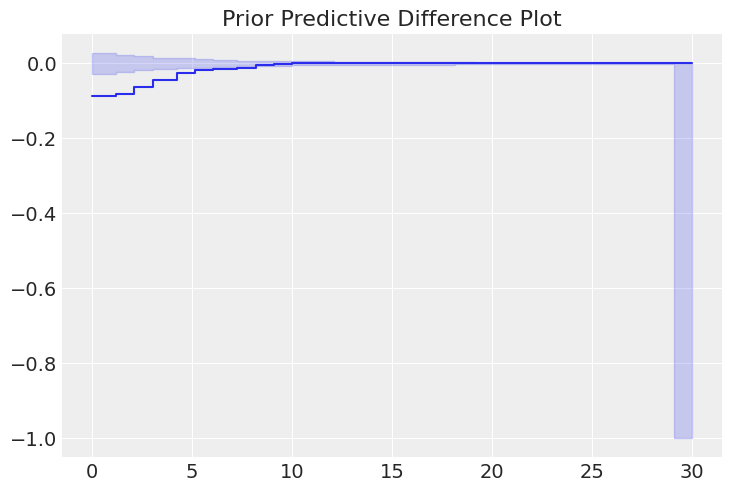

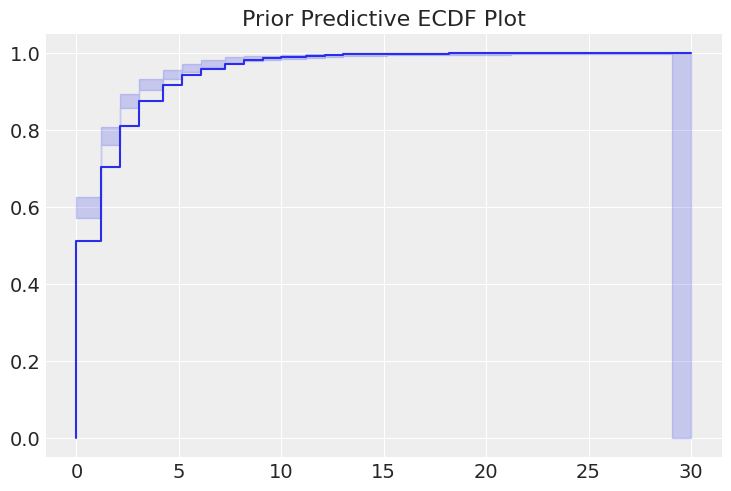

In [88]:
obs_freq_array = mcmc_fit.idata.observed_data['likelihood'][...,1]
prior_pred_freq_array = mcmc_fit.idata.prior_predictive['likelihood'][0][0][...,1]

az.plot_ecdf(prior_pred_freq_array, obs_freq_array, confidence_bands = True, difference=True).set_title("Prior Predictive Difference Plot")
az.plot_ecdf(prior_pred_freq_array, obs_freq_array, confidence_bands = True).set_title("Prior Predictive ECDF Plot")

Text(0.5, 1.0, 'Posterior Predictive ECDF Plot')

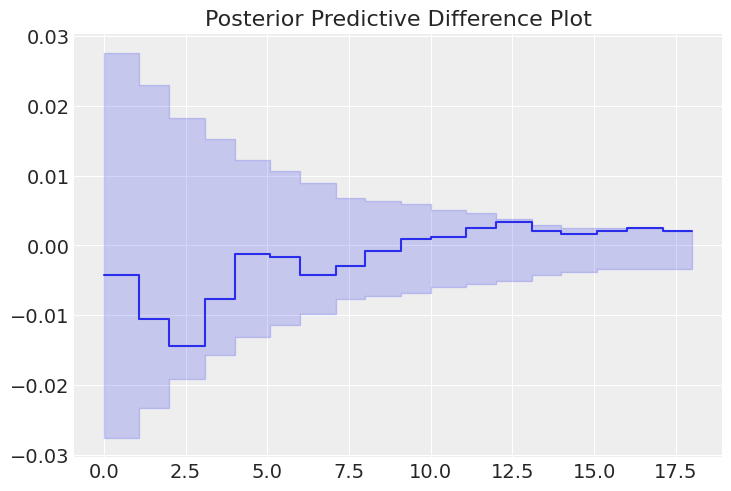

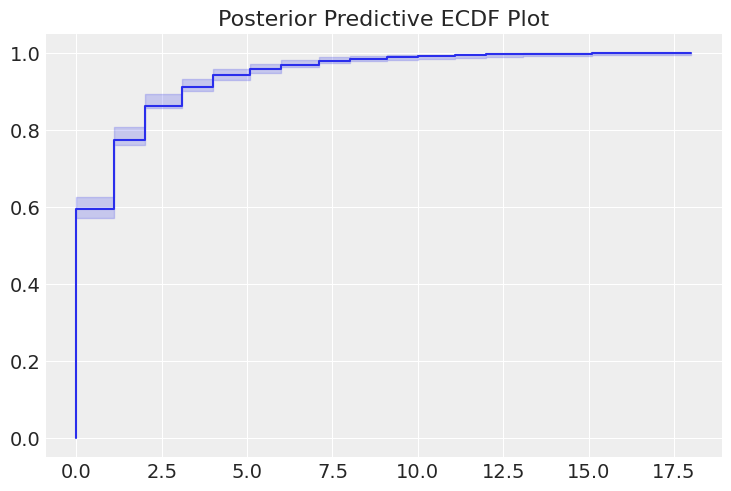

In [84]:
obs_freq_array = mcmc_fit.idata.observed_data['likelihood'][...,1]
post_pred_freq_array = mcmc_fit.idata.posterior_predictive['likelihood'][0][0][...,1]

az.plot_ecdf(post_pred_freq_array, obs_freq_array, confidence_bands = True, difference=True).set_title("Posterior Predictive Difference Plot")
az.plot_ecdf(post_pred_freq_array, obs_freq_array, confidence_bands = True).set_title("Posterior Predictive ECDF Plot")

https://python.arviz.org/en/stable/api/generated/arviz.plot_ecdf.html#arviz.plot_ecdf

# Plot the `ParetoNBDModel` Dropout and Purchase Rate Distributions for New Customers

In [196]:
customer_dropout_mcmc = mcmc_fit.distribution_new_customer_dropout()
customer_purchase_rate_mcmc = mcmc_fit.distribution_new_customer_purchase_rate()

customer_dropout_map = map_fit.distribution_new_customer_dropout()
customer_purchase_rate_map = map_fit.distribution_new_customer_purchase_rate()

Sampling: [population_dropout]


Sampling: [population_purchase_rate]


Sampling: [population_dropout]


Sampling: [population_purchase_rate]


array([[<Axes: title={'center': 'population_purchase_rate'}>]],
      dtype=object)

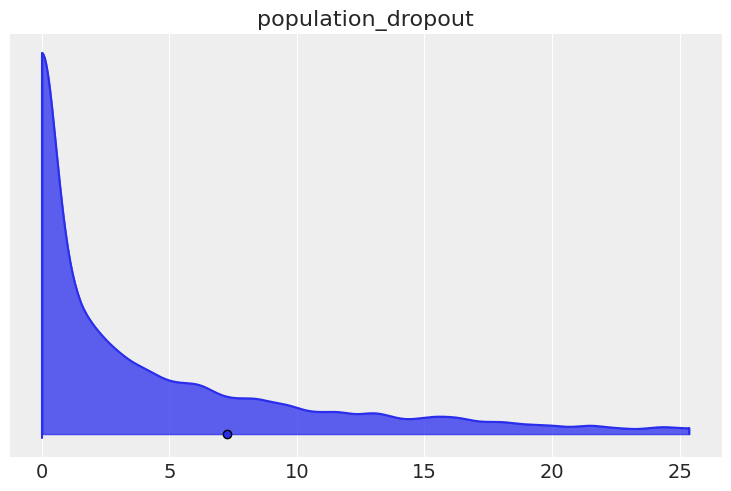

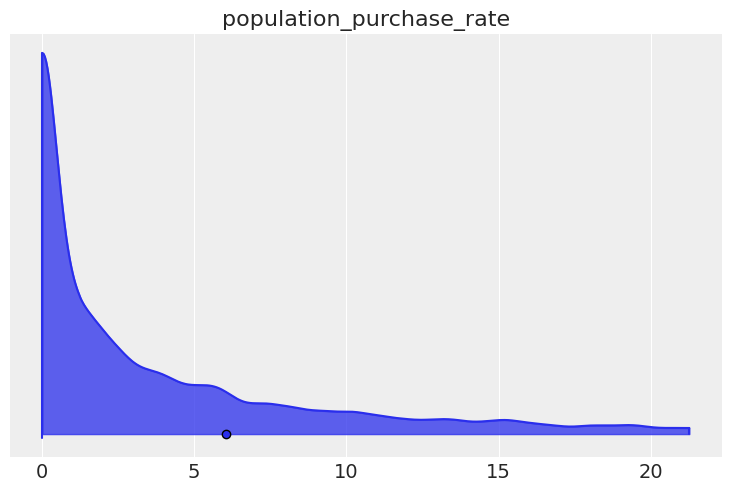

In [197]:
# az.plot_density only works with MCMC fits
az.plot_density(customer_dropout_mcmc,point_estimate="mean", shade=.75)
az.plot_density(customer_purchase_rate_mcmc,point_estimate="mean", shade=.75)

## Note that `az.plot_density` is not supported with MAP fits. `az.plot_dist()` supports both fit methods and also permits additional plotting options like rugplots and quantiles.

Text(0.5, 1.0, 'Customer Dropout Distribution')

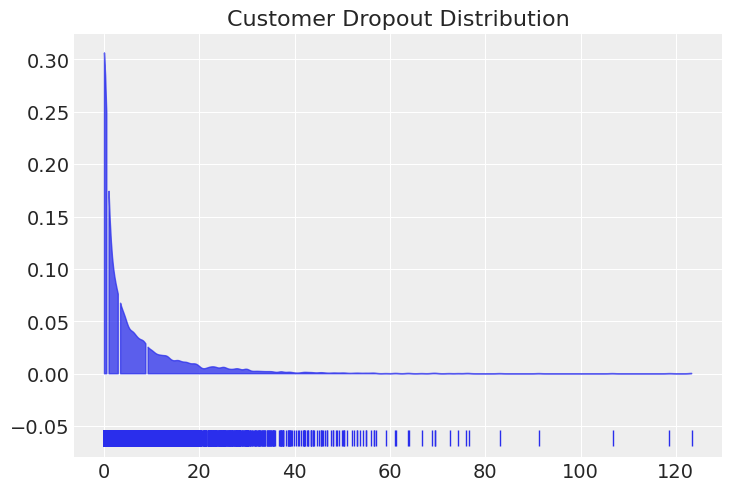

In [111]:
az.plot_dist(customer_dropout_mcmc, rug=True, quantiles=[.25, .5, .75], cumulative=False).set_title("Customer Dropout Distribution")

Text(0.5, 1.0, 'Customer Dropout Rate Distribution w/ MAP Fit')

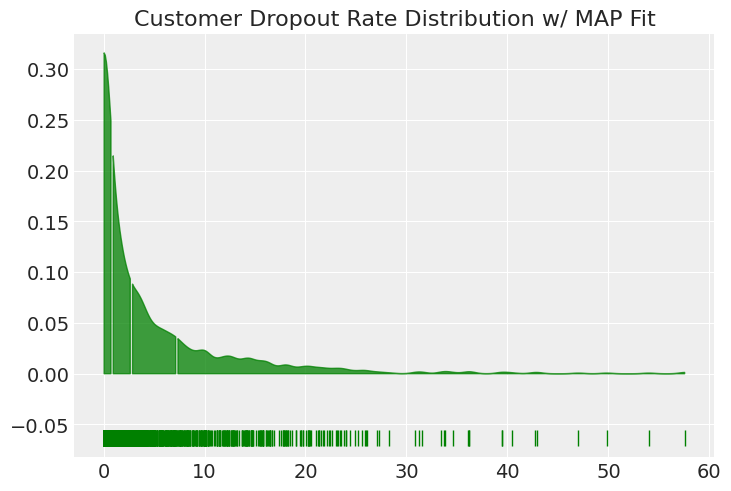

In [112]:
# Note the array indexing required for MAP fit plotting
az.plot_dist(customer_dropout_map[0][0], rug=True, color='g', quantiles=[.25, .5, .75], cumulative=False).set_title("Customer Dropout Rate Distribution w/ MAP Fit")

# Prior Predictive Plots for the Latent Dropout and Purchase Rate Distributions  are doable, but not directly supported. It's also important to know that since both distributions have identical Priors, there is no difference in plotting between them.

array([[<Axes: title={'center': 'x'}>]], dtype=object)

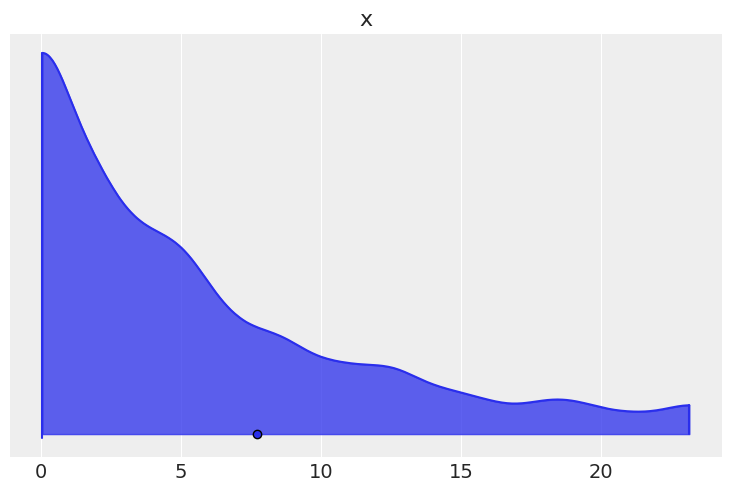

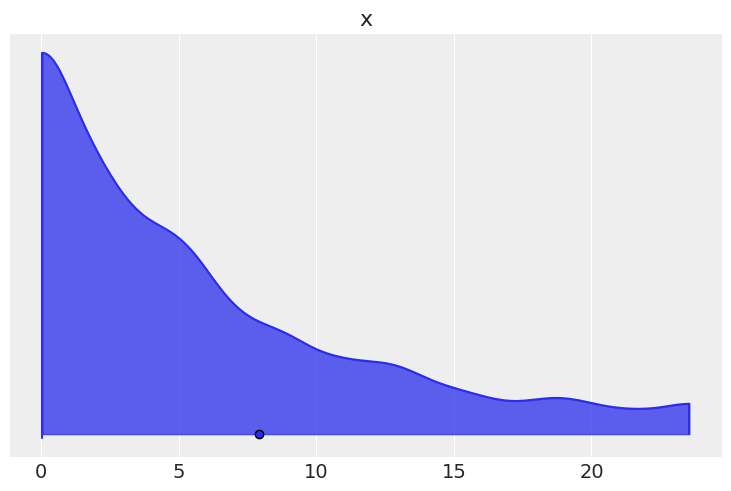

In [204]:
r_prior = mcmc_fit.idata.prior["r"]
alpha_prior = mcmc_fit.idata.prior["alpha"]
s_prior = mcmc_fit.idata.prior["s"]
beta_prior = mcmc_fit.idata.prior["beta"]

purchase_rate_dist = pm.draw(  
    pm.Gamma.dist(  
        alpha=r_prior.values[..., None].mean(),  
        beta=1 / alpha_prior.values[..., None].mean(),  
        shape=1000,  
    ),  
    random_seed=42)

dropout_rate_dist = pm.draw(  
    pm.Gamma.dist(  
        alpha=s_prior.values[..., None].mean(),  
        beta=1 / beta_prior.values[..., None].mean(),  
        shape=1000,  
    ),  
    random_seed=42)

az.plot_density(purchase_rate_dist,point_estimate="mean", shade=.75)
az.plot_density(dropout_rate_dist,point_estimate="mean", shade=.75)

# Bayesian p-value plot is odd to interpret, and the WAIC metric is throwing an error

<Axes: title={'center': 'likelihood / likelihood'}>

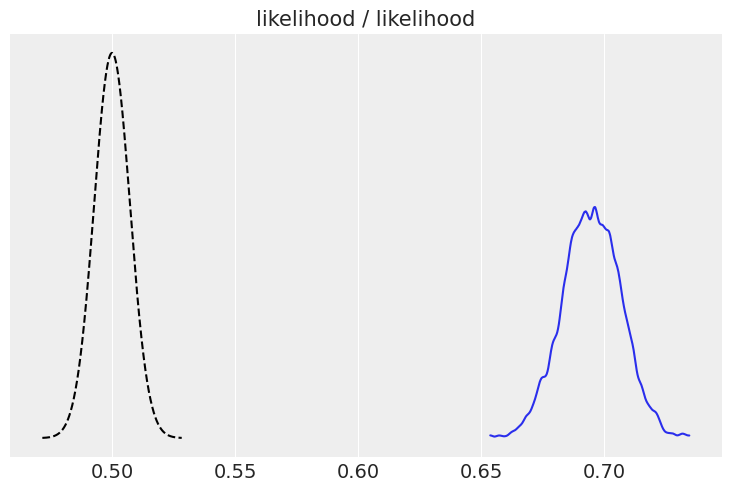

In [166]:
az.plot_bpv(mcmc_fit.idata, kind="p_value")

In [165]:
az.waic(mcmc_fit.idata)


TypeError: log likelihood not found in inference data object

# Predictive Methods for `ParetoNBDModel`

In [24]:
pnbd_map.save('pnbd.nc')
pnbd_map.load('pnbd.nc')

# Append all predictive methods to a pandas dataframe
#df['exp_prchs_mcmc'] = pnbd_mcmc.expected_purchases(future_t = 10).mean(("chain", "draw"))
df['exp_prchs_map'] = pnbd_map.expected_purchases(future_t = 10).mean(("chain", "draw"))

#df['prob_alive_mcmc'] = pnbd_mcmc.expected_probability_alive(future_t = 10).mean(("chain", "draw"))
df['prob_alive_map'] = pnbd_map.expected_probability_alive(future_t = 10).mean(("chain", "draw"))

#df['prchs_prob_mcmc'] = pnbd_mcmc.expected_purchase_probability(n_purchases=3,future_t=30).mean(("chain", "draw"))
df['prchs_prob_map'] = pnbd_map.expected_purchase_probability(n_purchases=3,future_t=30).mean(("chain", "draw"))

# This value does not change from customer to customer, but is shown here for completeness
#df['new_customer_mcmc'] = pnbd_mcmc.expected_purchases_new_customer(t = 100).mean().values
df['new_customer_map'] = pnbd_map.expected_purchases_new_customer(t = 100).mean().values

# For single customer predictions, arguments must still be provided as lists or numpy arrays
# Array lengths must match for all arguments
# pnbd_mcmc.expected_purchases(future_t = 10,
#                              customer_id = [1000],
#                              frequency = np.array([3]),
#                              recency = [20],
#                              T = [30]).mean(("chain", "draw"))

# # Use a for loop or list comprehension to iterate over multiple arguments:
# [pnbd_mcmc.expected_purchases(future_t = t) for t in [10,9,8]]

df.head(10)

/Users/coltallen/miniconda3/envs/pymc-dev/lib/python3.8/site-packages/arviz/data/inference_data.py:152: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(
/Users/coltallen/Projects/pymc-marketing/pymc_marketing/clv/models/pareto_nbd.py:175: UserWarning: The Pareto/NBD model is still experimental. Please see code examples in documentation if model fitting issues are encountered.
  warnings.warn(


,frequency,recency,T,monetary_value,customer_id,exp_prchs_mcmc,exp_prchs_map,prob_alive_mcmc,prob_alive_map,prchs_prob_map,new_customer_map
0,2,30.43,38.86,22.35,0,0.426163,0.429898,0.781540,0.789804,0.082505,2.257801
1,1,1.71,38.86,11.77,1,0.049964,0.050083,0.150524,0.151008,0.008571,2.257801
2,0,0.00,38.86,0.00,2,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
3,0,0.00,38.86,0.00,3,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
4,0,0.00,38.86,0.00,4,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
5,7,29.43,38.86,73.74,5,1.087263,1.102017,0.675588,0.685516,0.110536,2.257801
6,1,5.00,38.86,11.77,6,0.076542,0.077453,0.230524,0.233532,0.013254,2.257801
7,0,0.00,38.86,0.00,7,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
8,2,35.71,38.86,25.55,8,0.469376,0.471763,0.860708,0.866718,0.090540,2.257801
9,0,0.00,38.86,0.00,9,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801


# Formatting Data From Raw Transactions

In [56]:
d = [
        [1, "2015-01-01", 10.11],
        [1, "2015-02-06", 20.12],
        [2, "2015-01-01", 26.13],
        [3, "2015-01-01", 33.2],
        [3, "2015-01-02", 11.12],
        [3, "2015-01-05", 55.1],
        [4, "2015-01-16", 66.12],
        [4, "2015-02-02", 33.1],
        [4, "2015-02-05", 31.1],
        [5, "2015-01-16", 39.7],
        [5, "2015-01-17", 19.5],
        [5, "2015-01-18", 80.1],
    ]

raw_trans = pd.DataFrame(d, columns=["customer_id", "purchase_date", "monetary_value"])
raw_trans['purchase_date'] = pd.to_datetime(raw_trans['purchase_date'])
raw_trans

clv_summary(raw_trans,"customer_id","purchase_date","monetary_value")

,customer_id,frequency,recency,T,monetary_value
0,1,1.0,36.0,36.0,20.12
1,2,0.0,0.0,36.0,0.00
2,3,2.0,4.0,36.0,33.11
3,4,2.0,20.0,21.0,32.10
4,5,2.0,2.0,21.0,49.80


In [57]:
url_cdnow_trans = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/tests/clv/datasets/cdnow_transactions.csv"
raw_trans = pd.read_csv(url_cdnow_trans)

df_rfm = clv_summary(raw_trans,"id","date")